In [34]:
# Test your Gemini API
import google.generativeai as genai

# You'll enter your API key when prompted
api_key = input("Enter your Gemini API key: ")
genai.configure(api_key=api_key)

model = genai.GenerativeModel('gemini-pro')
# models = genai.list_models()
# print([m.name for m in models])

model = genai.GenerativeModel("models/gemini-2.5-pro")

# response = model.generate_content("Say hello to MGMT 599!")
# print(response.text)

In [7]:
# 1. Install & import dependencies
!pip install --upgrade google-cloud-bigquery pandas --quiet

from google.colab import auth
from google.cloud import bigquery
import pandas as pd

# 2. Authenticate your Google account
auth.authenticate_user()

# 3. Initialize BigQuery client (replace with your project ID if needed)
client = bigquery.Client(project="mgmt599-kunalghosh-lab1")

# 4. Reference your table
table_id = "mgmt599-kunalghosh-lab1.lab1_eda.superstore"

# 5. Fetch the table metadata
table = client.get_table(table_id)  # API request

# Build a multiline prompt listing each field
prompt_lines = [f"Schema for BigQuery table `{table_id}`:"]
for field in table.schema:
    prompt_lines.append(f"- {field.name} (_{field.field_type})")

# Join into one prompt string
chatbot_prompt = "\n".join(prompt_lines)

# (optional) inspect
print(chatbot_prompt)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 65.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
Schema for BigQuery table `mgmt599-kunalghosh-lab1.lab1_eda.superstore`:
- Row_ID (_INTEGER)
- Order_ID (_STRING)
- Order_Date (_DATE)
- Ship_Date (_DATE)
- Ship_Mode (_STRING)
- Customer_ID (_STRING)
- Customer_Name (_STRING)
- Segment (_STRING)
- Country (_STRING)
- City (_STRING)
- State (_STRING)
- Postal_Code (_INTEGER)
- Region (_STRING)
- Product_ID (_STRING)
- 

In [8]:
prompt = """

I have a retail dataset called Superstore with columns including:
Sales, Profit, Quantity, Discount, Category, Sub-Category,
Customer ID, Segment, Region, State, City, Order Date, Ship Date

As a retail analyst, what are the 5 most important business questions
I should investigate with this data? For each question, explain why
it matters and which columns I should analyze.
"""

# response = model.generate_content(prompt)
# print(response.text)

D - Discover (Basic Finding)

In [9]:
# 1. Install / upgrade the BigQuery client (you can skip if already installed)
!pip install --upgrade google-cloud-bigquery pandas --quiet

# 2. Authenticate your Google account
from google.colab import auth
auth.authenticate_user()

# 3. Import BigQuery client and pandas
from google.cloud import bigquery
import pandas as pd

# 4. Initialize the client (replace with your project if different)
client = bigquery.Client(project="mgmt599-kunalghosh-lab1")

# 5. Define your query
query = """
SELECT
  SUM(Sales)                   AS total_sales,
  SUM(Profit)                  AS total_profit,
  SUM(Quantity)                AS total_quantity,
  COUNT(DISTINCT Order_ID)     AS unique_orders,
  COUNT(DISTINCT Customer_ID)  AS unique_customers,
  COUNT(DISTINCT Product_ID)   AS unique_products,
  AVG(Sales)                   AS average_sales_per_item,
  AVG(Profit)                  AS average_profit_per_item,
  AVG(Discount)                AS average_discount
FROM
  `mgmt599-kunalghosh-lab1.lab1_eda.superstore`
"""

# 6. Run the query and convert to DataFrame
df = client.query(query).to_dataframe()

# 7. Inspect the results
df


,total_sales,total_profit,total_quantity,unique_orders,unique_customers,unique_products,average_sales_per_item,average_profit_per_item,average_discount
0,2.297201e+06,286397.0217,37873,5009,793,1862,229.858001,28.656896,0.156203


I - Investigate (Dig Deeper)

In [10]:
%%bigquery superstore

SELECT * FROM `mgmt599-kunalghosh-lab1.lab1_eda.superstore`

Query is running:   0%|          |

Downloading:   0%|          |

In [11]:
prompt = """
Act as expert in Python, Google Colab, Big Query.
The table scheme is in attachment.
The data is in pandas imported from BigQuery using the query below:
%%bigquery superstore SELECT * FROM mgmt599-kunalghosh-lab1.lab1_eda.Superstore

I would like a pivot table with Category, Sub-category, Discount as rows, order year, order month as columns and Sum of profit as Values. For style, ensure following:
Keep all Profit > 0 = white background. Cell with Profit < 0 = light red
draw borders and set discount only single decimal.
add the Grand Total Profit column on right of Discount before monthwise columns.
Color the discount column cell of those rows for which Grand Total column > 0 to Green otherwise Light Red if Grand Total column < 0.
Provide the python code.
"""

# response = model.generate_content(prompt)
# print(response.text)

Pivot Table for Segmentation Analysis (Product Sub-Category, Discount levelwise) and Temporal Analysis (Month by Month through years)

In [12]:
# 2) Imports & preprocessing
import pandas as pd

df = superstore.copy()
df['order_date']   = pd.to_datetime(df['Order_Date'])
df['order_year']   = df['order_date'].dt.year
df['order_month']  = df['order_date'].dt.month
df['profit_int']   = df['Profit'].round().astype(int)

# 3) Build the profit pivot
pivot = pd.pivot_table(
    df,
    values='profit_int',
    index=['Category','Sub_Category','Discount'],
    columns=['order_year','order_month'],
    aggfunc='sum',
    fill_value=0
)

# 4) Flatten the columns to “YYYY-MM”
pivot.columns = [f"{y}-{m:02d}" for y, m in pivot.columns]

# 5) Reset index to get a flat DataFrame
df_pivot = pivot.reset_index()

# 6) Round Discount to one decimal
df_pivot['Discount'] = df_pivot['Discount'].round(1)

# 7) Compute total Quantity per row and merge in
qty = (
    df
    .groupby(['Category','Sub_Category','Discount'], as_index=False)['Quantity']
    .sum()
)
df_pivot = df_pivot.merge(qty, on=['Category','Sub_Category','Discount'])

# 8) Identify profit-by-month columns
profit_months = [
    c for c in df_pivot.columns
    if c not in ['Category','Sub_Category','Discount','Quantity']
]

# 9) Compute yearly totals
years = sorted({c.split('-')[0] for c in profit_months})
for y in years:
    df_pivot[f'{y}_Total'] = df_pivot[[c for c in profit_months if c.startswith(f'{y}-')]].sum(axis=1)
year_totals = [f'{y}_Total' for y in years]

# 10) Compute Grand Total profit
df_pivot['Grand_Total'] = df_pivot[profit_months].sum(axis=1)

# 11) Reorder so Quantity sits before Grand_Total, then months, then yearly totals
new_order = (
    ['Category','Sub_Category','Discount','Quantity','Grand_Total']
    + profit_months
    + year_totals
)
df_pivot = df_pivot[new_order]

# 12) Styling helpers

# Highlight Discount & Quantity cells green/red based on Grand_Total
def highlight_discount_and_qty(row):
    styles = []
    for col in row.index:
        if col in ('Discount','Quantity'):
            color = '#ccffcc' if row['Grand_Total'] > 0 else '#ffcccc'
            styles.append(f'background-color: {color};')
        else:
            styles.append('')
    return styles

# Highlight negative profits (monthly, yearly, and grand total)
def highlight_neg(val):
    return 'background-color: #ffcccc;' if isinstance(val, (int,float)) and val < 0 else ''

# Thin black borders
table_styles = [
    {'selector': 'table',    'props': [('border-collapse','collapse')]},
    {'selector': 'th, td',   'props': [('border','1px solid black')]},
    {'selector': 'th',       'props': [('background-color','#f2f2f2')]},
]

# 13) Apply styling
styled = (
    df_pivot.style
            .apply(highlight_discount_and_qty, axis=1)
            .map(highlight_neg, subset=profit_months + year_totals + ['Grand_Total'])
            .format({'Discount':'{:.1f}'})
            .set_table_styles(table_styles)
            .set_caption("Monthly Profitability + Yearly Totals with Discount & Quantity Highlight")
)

# 14) Display
styled


,Category,Sub_Category,Discount,Quantity,Grand_Total,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2014_Total,2015_Total,2016_Total,2017_Total
0,Furniture,Bookcases,0.0,211,6073,40,0,0,0,0,57,260,172,36,0,236,79,0,82,137,126,141,0,116,48,118,0,1143,21,453,53,0,89,0,291,126,24,86,283,97,52,72,79,102,0,485,227,96,23,323,167,0,133,880,1932,1554,1707
1,Furniture,Bookcases,0.2,167,1416,7,0,58,-18,27,0,7,0,21,-36,30,12,0,0,0,0,42,0,-14,264,-26,38,-70,-30,0,0,0,31,0,49,226,0,91,21,160,-12,0,17,0,107,0,192,211,0,14,-7,-30,34,108,204,566,538
2,Furniture,Bookcases,0.2,167,131,0,0,0,0,0,-44,0,-8,-10,0,-88,87,0,0,0,0,0,0,6,0,135,159,16,64,-68,0,-22,-5,0,-39,22,0,64,0,32,0,0,36,-29,-38,-16,-9,0,0,0,-16,-122,24,-63,380,-16,-170
3,Furniture,Bookcases,0.3,43,-555,0,0,0,0,0,0,0,0,-70,0,-30,0,0,0,-36,0,0,0,-178,0,0,0,0,-72,0,0,0,0,0,0,0,0,0,0,0,-14,0,0,0,0,0,0,0,-37,-118,0,0,0,-100,-286,-14,-155
4,Furniture,Bookcases,0.3,43,-2390,0,0,0,0,0,-20,0,0,-97,0,-13,0,-438,0,-104,0,0,0,0,-114,0,0,-94,-47,0,0,-14,0,0,0,0,-53,-542,0,-225,-138,0,-17,-66,-42,-125,-96,0,0,0,-92,-41,-12,-130,-797,-972,-491
5,Furniture,Bookcases,0.5,76,-4256,-53,0,-200,0,-217,0,0,0,0,0,-251,0,-244,0,0,-211,0,-377,0,-205,-1665,-16,0,0,0,0,-409,0,0,0,-78,-82,0,0,-49,0,0,0,0,0,-65,0,-45,-89,0,0,0,0,-721,-2718,-618,-199
6,Furniture,Bookcases,0.7,68,-3898,-321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-192,0,0,-104,-248,-931,0,0,-99,0,0,0,0,0,0,-191,0,0,0,0,0,0,-510,0,0,0,-369,-385,0,-548,-321,-1475,-290,-1812
7,Furniture,Chairs,0.0,540,21929,1057,15,285,13,244,613,232,440,257,985,278,1054,0,266,189,386,770,80,88,16,1828,232,773,468,0,261,89,378,881,21,136,0,825,157,341,1528,73,0,1054,227,606,776,100,599,699,9,745,1855,5473,5096,4617,6743
8,Furniture,Chairs,0.1,313,7109,0,0,65,0,0,0,11,0,835,-7,39,198,0,15,64,3,21,170,322,0,76,0,923,119,0,40,55,502,59,7,104,56,140,174,81,588,2,0,62,0,0,208,114,98,1312,5,460,188,1141,1713,1806,2449
9,Furniture,Chairs,0.2,889,4279,0,-24,184,242,93,84,48,9,389,-46,78,537,-7,39,213,-19,92,-127,-66,57,47,-66,158,538,10,0,155,227,-47,60,184,83,99,191,148,70,-82,175,-17,-76,-34,139,72,143,233,-18,-12,123,1594,859,1180,646


Finds every 2017 order where the actual Discount exceeded your capped values for the given sub-categories.

Reconstructs an implied list price (Sales ÷ (1–Discount)) and then recalculates what Sales and Profit would have been if you’d only applied the capped discount.

Computes the difference (new_profit – actual profit) as the “prevented loss” (i.e. extra profit you’d have retained).

Finally, it rolls up those improvements by Sub-Category and reports the total benefit for 2017.

In [13]:
# 2) Imports & preprocessing
import pandas as pd

df = superstore.copy()
df['order_date']  = pd.to_datetime(df['Order_Date'])
df['order_year']  = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month

# 3) Define your max‐discount caps by Sub-Category
caps = {
    'Binders':  0.20,
    'Machines': 0.30,
    'Tables':   0.00,
    'Storage':  0.00,
    'Phones':   0.20
}

# 4) Filter to 2017 orders in the affected Sub-Categories
mask = (
    (df['order_year'] == 2017) &
    (df['Sub_Category'].isin(caps.keys())) &
    (df['Discount'] > df['Sub_Category'].map(caps))
)
df_cap = df.loc[mask].copy()

# 5) Reconstruct list price, then simulate capping the discount
df_cap['cap_discount'] = df_cap['Sub_Category'].map(caps)
df_cap['list_price']   = df_cap['Sales'] / (1 - df_cap['Discount'])
df_cap['new_sales']    = df_cap['list_price'] * (1 - df_cap['cap_discount'])

# 6) Estimate new profit assuming the same margin %
df_cap['margin_rate']  = df_cap['Profit'] / df_cap['Sales']
df_cap['new_profit']   = df_cap['new_sales'] * df_cap['margin_rate']

# 7) Compute the prevented‐loss (profit improvement)
df_cap['profit_improvement'] = df_cap['new_profit'] - df_cap['Profit']

# 8) Summarize by Sub-Category and total
impact_by_sub = (
    df_cap
    .groupby('Sub_Category', as_index=False)
    ['profit_improvement']
    .sum()
    .rename(columns={'profit_improvement':'prevented_loss_$'})
)
total_prevented = impact_by_sub['prevented_loss_$'].sum()

# 9) Display results
print(impact_by_sub.to_string(index=False))
print(f"\nTotal prevented loss in 2017 by capping discounts: ${total_prevented:,.0f}")


Sub_Category  prevented_loss_$
     Binders     -40477.538100
    Machines      -8442.975310
      Phones       -796.878467
     Storage       -264.710950
      Tables      -7789.620810

Total prevented loss in 2017 by capping discounts: $-57,772


In [14]:
# 2) Imports
import pandas as pd
import plotly.express as px

# 3) Copy & compute discount dollars
df = superstore.copy()
df['Discount_Amount'] = df['Sales'] * df['Discount']

# 4) Aggregate by Sub-Category
agg_sub = (
    df
    .groupby('Sub_Category', as_index=False)
    .agg(
        Total_Discount    = ('Discount_Amount', 'sum'),
        Total_Profit      = ('Profit',          'sum'),
        Total_Sales       = ('Sales',           'sum')
    )
)

# 5) Compute Return on Discount
agg_sub['Return_on_Discount'] = agg_sub['Total_Profit'] / agg_sub['Total_Discount']

# 6) Determine cut-offs
x_cut = agg_sub['Total_Discount'].median()
y_cut = agg_sub['Return_on_Discount'].median()

# 7) Assign each Sub-Category to a quadrant
def assign_quadrant(r):
    if   r['Total_Discount']    >= x_cut and r['Return_on_Discount'] >= y_cut:
        return 'Effective Promos'      # big discount spend, high return
    elif r['Total_Discount']    >= x_cut and r['Return_on_Discount'] <  y_cut:
        return 'Bleeders'              # big discount spend, low return
    elif r['Total_Discount']    <  x_cut and r['Return_on_Discount'] >= y_cut:
        return 'High ROI / Low Spend'  # little discount spend, high return
    else:
        return 'Underinvested'         # little discount spend, low return

agg_sub['Quadrant'] = agg_sub.apply(assign_quadrant, axis=1)

# 8) Plot the 2×2 quadrant scatter
fig = px.scatter(
    agg_sub,
    x='Total_Discount',
    y='Return_on_Discount',
    color='Quadrant',
    size='Total_Sales',
    text='Sub_Category',
    labels={
        'Total_Discount'      : 'Total Discount $',
        'Return_on_Discount'  : 'Return on Discount\n(Profit ÷ Discount $)',
        'Total_Sales'         : 'Total Sales'
    },
    title='Sub-Category × Return on Discount Quadrant Analysis'
)

# 9) Add median cut-lines
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 10) Tweak text placement, axis formats, and layout
fig.update_traces(textposition='top center', marker_opacity=0.75)
fig.update_layout(
    xaxis_title='Total Discount $',
    yaxis_title='Return on Discount',
    yaxis_tickformat='.2f',
    legend_title_text='Segment',
    margin=dict(l=40, r=40, t=60, b=40),
    height=600
)

# 11) Show the figure
fig.show()


In [15]:
# 2) Imports
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import plotly.express as px

# 3) Preprocess dates & compute a “price factor” (1 – discount)
df = superstore.copy()
df['order_date']      = pd.to_datetime(df['Order_Date'])
df['YearMonth']       = df['order_date'].dt.to_period('M').astype(str)
df['Price_Factor']    = 1 - df['Discount']  # e.g. 0.20 discount → price factor 0.80

# 4) Aggregate to month‐level per Sub-Category
monthly = (
    df
    .groupby(['Sub_Category','YearMonth'], as_index=False)
    .agg(
        Total_Quantity = ('Quantity', 'sum'),
        Avg_Price_Factor = ('Price_Factor', 'mean')
    )
)

# 5) Keep only valid rows (no zero or negative price factor)
monthly = monthly[monthly['Avg_Price_Factor'] > 0]

# 6) Estimate log‐log elasticity for each Sub-Category
elasticities = []
for subcat, grp in monthly.groupby('Sub_Category'):
    # require at least 6 points to get a stable estimate
    if len(grp) < 6:
        continue
    # run a simple OLS: log(Q) ~ log(price_factor)
    model = smf.ols('np.log(Total_Quantity) ~ np.log(Avg_Price_Factor)', data=grp).fit()
    elasticities.append({
        'Sub_Category': subcat,
        'Elasticity':   model.params['np.log(Avg_Price_Factor)'],
        'p_value':      model.pvalues['np.log(Avg_Price_Factor)'],
        'n_obs':        int(model.nobs)
    })

elast_df = pd.DataFrame(elasticities).sort_values('Elasticity')

# 7) Plot the results
fig = px.bar(
    elast_df,
    x='Sub_Category',
    y='Elasticity',
    text='Elasticity',
    color='Elasticity',
    color_continuous_scale='RdBu_r',
    labels={'Elasticity':'Price Elasticity'},
    title='Estimated Price Elasticity of Demand by Sub-Category'
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_tickangle=45,
    yaxis_title='Elasticity (log‐log slope)',
    margin=dict(l=40, r=40, t=60, b=120),
    height=600
)
fig.show()


In [16]:
# 2) Imports & initial DataFrame
import pandas as pd
import plotly.express as px

df = superstore.copy()

# 3) Compute per–Sub-Category metrics
agg = (
    df
    .groupby('Sub_Category', as_index=False)
    .agg(
        Avg_Discount = ('Discount', 'mean'),
        Total_Sales   = ('Sales',    'sum'),
        Total_Profit  = ('Profit',   'sum')
    )
)

# 4) Profit Margin = Total_Profit / Total_Sales
agg['Profit_Margin'] = agg['Total_Profit'] / agg['Total_Sales']

# 5) Determine your quadrant cut‐offs (medians)
x_cut = agg['Avg_Discount'].median()
y_cut = agg['Profit_Margin'].median()

# 6) Assign each Sub‐Category to a “promotion efficiency” quadrant
def assign_quadrant(row):
    if row['Avg_Discount'] <  x_cut and row['Profit_Margin'] >= y_cut:
        return 'Premium'           # low discount, high margin
    elif row['Avg_Discount'] >= x_cut and row['Profit_Margin'] >= y_cut:
        return 'Promoted Star'     # high discount, high margin
    elif row['Avg_Discount'] >= x_cut and row['Profit_Margin'] <  y_cut:
        return 'Bleeder'           # high discount, low margin
    else:
        return 'Stagnant'          # low discount, low margin

agg['Quadrant'] = agg.apply(assign_quadrant, axis=1)

# 7) Scatter plot: Discount vs Profitability
fig = px.scatter(
    agg,
    x='Avg_Discount',
    y='Profit_Margin',
    color='Quadrant',
    size='Total_Sales',
    text='Sub_Category',
    labels={
        'Avg_Discount':'Average Discount',
        'Profit_Margin':'Profit Margin',
        'Total_Sales':'Total Sales'
    },
    title='Promotion Efficiency: Discount vs Profitability'
)

# 8) Add median cut‐lines
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 9) Format axes as percentages and position labels
fig.update_layout(
    xaxis_tickformat='.0%',
    yaxis_tickformat='.0%',
    legend_title_text='Segment',
    margin=dict(l=40, r=40, t=60, b=40),
    height=600
)
fig.update_traces(textposition='top center', marker_opacity=0.75)

# 10) Show
fig.show()


In [17]:
# 2) Imports & copy
import pandas as pd
import plotly.express as px

df = superstore.copy()

# 3) Compute per-Sub-Category metrics:
#    – Avg Discount
#    – Avg Order Value (mean sales per line item; proxy for order value)
#    – Total Orders (count of unique orders)
agg = (
    df
    .groupby('Sub_Category', as_index=False)
    .agg(
        Avg_Discount     = ('Discount', 'mean'),
        Avg_Order_Value  = ('Sales',    'mean'),
        Total_Orders     = ('Order_ID', pd.Series.nunique)
    )
)

# 4) Determine quadrant cut-offs (medians)
x_cut = agg['Avg_Discount'].median()
y_cut = agg['Avg_Order_Value'].median()

# 5) Assign each Sub-Category to one of four “Revenue vs Promotion” segments
def assign_segment(r):
    if   r['Avg_Discount'] <  x_cut and r['Avg_Order_Value'] >= y_cut:
        return 'Premium'              # low discount, high order value
    elif r['Avg_Discount'] >= x_cut and r['Avg_Order_Value'] >= y_cut:
        return 'Promoted Big Spenders'# high discount, high order value
    elif r['Avg_Discount'] >= x_cut and r['Avg_Order_Value'] <  y_cut:
        return 'Heavy Discounters'    # high discount, low order value
    else:
        return 'Stagnant Value'       # low discount, low order value

agg['Segment'] = agg.apply(assign_segment, axis=1)

# 6) Build the 2×2 quadrant scatter
fig = px.scatter(
    agg,
    x='Avg_Discount',
    y='Avg_Order_Value',
    color='Segment',
    size='Total_Orders',
    text='Sub_Category',
    labels={
      'Avg_Discount':'Average Discount',
      'Avg_Order_Value':'Average Order Value',
      'Total_Orders':'# Orders'
    },
    title='Order Value × Discount (Revenue vs Promotion Depth)'
)

# 7) Add the median cut‐lines
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 8) Format axes & text
fig.update_traces(textposition='top center', marker_opacity=0.7)
fig.update_layout(
    xaxis_tickformat='.0%',
    yaxis_tickprefix='$',
    legend_title_text='Segment',
    margin=dict(l=40, r=40, t=60, b=40),
    height=600
)

# 9) Display
fig.show()


In [18]:
# 2) Imports & preprocessing
import pandas as pd
import plotly.express as px

df = superstore.copy()
df['Order_Date']  = pd.to_datetime(df['Order_Date'])
df['Year']        = df['Order_Date'].dt.year

# 3) Summarize sales & profit by Sub-Category
agg = (
    df
    .groupby('Sub_Category', as_index=False)
    .agg(Total_Sales = ('Sales','sum'),
         Total_Profit= ('Profit','sum'))
)
agg['Profit_Margin'] = agg['Total_Profit'] / agg['Total_Sales']

# 4) Compute YoY sales growth (last two years only)
sales_year = (
    df
    .groupby(['Sub_Category','Year'], as_index=False)
    .agg(Yearly_Sales=('Sales','sum'))
)
pivot_sales = sales_year.pivot(index='Sub_Category', columns='Year', values='Yearly_Sales')
years = sorted(df['Year'].unique())
if len(years) >= 2:
    prior, latest = years[-2], years[-1]
    pivot_sales['YOY_Growth'] = (pivot_sales[latest] - pivot_sales[prior]) / pivot_sales[prior]
else:
    pivot_sales['YOY_Growth'] = 0.0

agg = agg.merge(pivot_sales['YOY_Growth'].reset_index(), on='Sub_Category', how='left')

# 5) Decide quadrant cut-offs (medians)
x_cut = agg['Profit_Margin'].median()
y_cut = agg['YOY_Growth'].median()

# 6) Assign each sub-category to a BCG quadrant
def assign_quadrant(r):
    if   r['Profit_Margin'] >= x_cut and r['YOY_Growth'] >= y_cut: return 'Star'
    elif r['Profit_Margin'] >= x_cut and r['YOY_Growth'] <  y_cut: return 'Cash Cow'
    elif r['Profit_Margin'] <  x_cut and r['YOY_Growth'] >= y_cut: return 'Question Mark'
    else:                                                             return 'Dog'

agg['Quadrant'] = agg.apply(assign_quadrant, axis=1)

# 7) Choose marker symbols for each quadrant
symbol_map = {
    'Star'         : 'star',
    'Cash Cow'     : 'circle',
    'Question Mark': 'diamond',
    'Dog'          : 'square'
}

# 8) Build the scatter with text labels
fig = px.scatter(
    agg,
    x='Profit_Margin',
    y='YOY_Growth',
    color='Quadrant',
    symbol='Quadrant',
    symbol_map=symbol_map,
    size='Total_Sales',
    text='Sub_Category',
    labels={
        'Profit_Margin':'Profit Margin (Proxy for Market Share)',
        'YOY_Growth'  :'YoY Sales Growth',
        'Total_Sales' :'Total Sales'
    },
    title='2×2 BCG-Style Quadrant: Market (Profit) vs Growth'
)

# 9) Add the median lines
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 10) Tweak text positioning & layout
fig.update_traces(
    textposition='top center',
    textfont_size=12,
    marker=dict(opacity=0.7)
)
fig.update_layout(
    xaxis_tickformat='.0%',
    yaxis_tickformat='.0%',
    legend_title_text='Quadrant',
    margin=dict(l=40, r=40, t=60, b=40),
    height=600
)

fig.show()


In [19]:
# 2) Imports
import pandas as pd
import plotly.express as px

# 3) Copy & preprocess
df = superstore.copy()

# 4) Aggregate Volume (Sales) and Profit by Sub-Category
agg = (
    df
    .groupby('Sub_Category', as_index=False)
    .agg(
        Total_Volume = ('Sales', 'sum'),    # here volume = sales $
        Total_Profit = ('Profit', 'sum')
    )
)

# 5) Compute Profit Margin
agg['Profit_Margin'] = agg['Total_Profit'] / agg['Total_Volume']

# 6) Determine quadrant cut-offs (medians)
x_cut = agg['Total_Volume'].median()
y_cut = agg['Profit_Margin'].median()

# 7) Assign each Sub-Category to one of four segments
def assign_quadrant(r):
    if   r['Total_Volume'] >= x_cut and r['Profit_Margin'] >= y_cut:
        return 'Cash Generators'    # high volume, high margin
    elif r['Total_Volume'] >= x_cut and r['Profit_Margin'] <  y_cut:
        return 'Loss Leaders'       # high volume, low margin
    elif r['Total_Volume'] <  x_cut and r['Profit_Margin'] >= y_cut:
        return 'Specialty Winners'  # low volume, high margin
    else:
        return 'Underperformers'    # low volume, low margin

agg['Segment'] = agg.apply(assign_quadrant, axis=1)

# 8) Build the scatter chart
fig = px.scatter(
    agg,
    x='Total_Volume',
    y='Profit_Margin',
    color='Segment',
    size='Total_Volume',
    text='Sub_Category',
    labels={
        'Total_Volume':'Total Sales Volume',
        'Profit_Margin':'Profit Margin',
        'Segment':'Segment'
    },
    title='Velocity vs Profitability: Margin × Volume Quadrant Analysis'
)

# 9) Add median lines to delineate quadrants
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 10) Format axes and layout
fig.update_layout(
    xaxis_title='Total Sales Volume',
    yaxis_title='Profit Margin',
    yaxis_tickformat='.0%',
    margin=dict(l=40, r=40, t=60, b=40),
    height=600
)
fig.update_traces(textposition='top center', marker_opacity=0.7)

# 11) Show the figure
fig.show()


In [20]:
# 2) Imports
import pandas as pd
import plotly.express as px

# 3) Copy and compute per-Sub-Category order metrics
df = superstore.copy()

# Aggregate total sales, total profit, and unique order count per Sub-Category
metrics = (
    df
    .groupby('Sub_Category', as_index=False)
    .agg(
        Total_Sales  = ('Sales',    'sum'),
        Total_Profit = ('Profit',   'sum'),
        Total_Orders = ('Order_ID', pd.Series.nunique)
    )
)

# Compute average sales & profit per order
metrics['Avg_Order_Sales'] = metrics['Total_Sales'] / metrics['Total_Orders']
metrics['Avg_Order_Profit'] = metrics['Total_Profit'] / metrics['Total_Orders']

# 4) Determine median cut-offs for each axis
x_cut = metrics['Avg_Order_Sales'].median()
y_cut = metrics['Avg_Order_Profit'].median()

# 5) Assign each Sub-Category to a quadrant
def assign_quadrant(row):
    if   row['Avg_Order_Sales'] >= x_cut and row['Avg_Order_Profit'] >= y_cut:
        return 'Big & Profitable'
    elif row['Avg_Order_Sales'] <  x_cut and row['Avg_Order_Profit'] >= y_cut:
        return 'Small & Profitable'
    elif row['Avg_Order_Sales'] >= x_cut and row['Avg_Order_Profit'] <  y_cut:
        return 'Big & Unprofitable'
    else:
        return 'Small & Unprofitable'

metrics['Quadrant'] = metrics.apply(assign_quadrant, axis=1)

# 6) Plot the 2×2 quadrant scatter
fig = px.scatter(
    metrics,
    x='Avg_Order_Sales',
    y='Avg_Order_Profit',
    color='Quadrant',
    size='Total_Orders',
    text='Sub_Category',
    labels={
        'Avg_Order_Sales':'Avg Sales per Order',
        'Avg_Order_Profit':'Avg Profit per Order',
        'Total_Orders':'# of Orders'
    },
    title='Order Size × Order Profit by Sub-Category'
)

# 7) Add median cut-lines to delineate quadrants
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 8) Tidy up text and layout
fig.update_traces(textposition='top center', marker_opacity=0.7)
fig.update_layout(
    xaxis_title='Avg Sales per Order',
    yaxis_title='Avg Profit per Order',
    margin=dict(l=40, r=40, t=60, b=40),
    height=600
)

# 9) Display
fig.show()


In [21]:
# 2) Imports
import pandas as pd
import plotly.express as px

# 3) Copy & compute metrics per Sub-Category
df = superstore.copy()
agg = (
    df
    .groupby('Sub_Category', as_index=False)
    .agg(
        Unique_Customers = ('Customer_ID', 'nunique'),
        Total_Profit     = ('Profit',      'sum'),
        Total_Sales      = ('Sales',       'sum')
    )
)
# Compute profit margin
agg['Profit_Margin'] = agg['Total_Profit'] / agg['Total_Sales']

# 4) Determine medians for axes
x_cut = agg['Unique_Customers'].median()
y_cut = agg['Profit_Margin'].median()

# 5) Assign each Sub-Category to a quadrant
def assign_quadrant(r):
    if   r['Unique_Customers'] >= x_cut and r['Profit_Margin'] >= y_cut:
        return 'Mass Market Profits'
    elif r['Unique_Customers'] >= x_cut and r['Profit_Margin'] <  y_cut:
        return 'Mass Market Low Margin'
    elif r['Unique_Customers'] <  x_cut and r['Profit_Margin'] >= y_cut:
        return 'Niche Profits'
    else:
        return 'Niche Low Margin'

agg['Quadrant'] = agg.apply(assign_quadrant, axis=1)

# 6) Build the 2×2 quadrant scatter plot
fig = px.scatter(
    agg,
    x='Unique_Customers',
    y='Profit_Margin',
    color='Quadrant',
    size='Total_Sales',
    text='Sub_Category',
    labels={
        'Unique_Customers':'# of Unique Customers',
        'Profit_Margin'    :'Profit Margin',
        'Total_Sales'      :'Total Sales'
    },
    title='Customer Diversification by Sub-Category: Customers vs Profit Margin'
)

# 7) Add median cut‐lines
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 8) Tweak layout & formatting
fig.update_traces(textposition='top center', marker_opacity=0.7)
fig.update_layout(
    xaxis_title='# of Unique Customers',
    yaxis_title='Profit Margin',
    yaxis_tickformat='.0%',
    legend_title_text='Segment',
    margin=dict(l=40, r=40, t=60, b=40),
    height=600
)

# 9) Show the figure
fig.show()


In [22]:
# 2) Imports
import pandas as pd
import plotly.express as px

# 3) Copy & compute metrics
df = superstore.copy()

agg = (
    df
    .groupby('Sub_Category', as_index=False)
    .agg(
        Order_Count    = ('Order_ID', 'nunique'),
        Geo_Dispersion = ('City',     'nunique'),
        Total_Sales    = ('Sales',    'sum')
    )
)

# 4) Determine median cut-offs
x_cut = agg['Geo_Dispersion'].median()
y_cut = agg['Order_Count'].median()

# 5) Assign each Sub-Category to a quadrant
def assign_quadrant(r):
    if   r['Geo_Dispersion'] >= x_cut and r['Order_Count']    >= y_cut:
        return 'Broad & Busy'
    elif r['Geo_Dispersion'] <  x_cut and r['Order_Count']    >= y_cut:
        return 'Narrow & Busy'
    elif r['Geo_Dispersion'] >= x_cut and r['Order_Count']    <  y_cut:
        return 'Broad & Quiet'
    else:
        return 'Narrow & Quiet'

agg['Quadrant'] = agg.apply(assign_quadrant, axis=1)

# 6) Plot the 2×2 quadrant scatter
fig = px.scatter(
    agg,
    x='Geo_Dispersion',
    y='Order_Count',
    color='Quadrant',
    size='Total_Sales',
    text='Sub_Category',
    labels={
        'Geo_Dispersion': '# of Unique Cities',
        'Order_Count'   : '# of Orders',
        'Total_Sales'   : 'Total Sales'
    },
    title='Order Count × Geo-Dispersion Quadrant Analysis'
)

# 7) Add median cut-lines
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 8) Final layout tweaks
fig.update_traces(textposition='top center', marker_opacity=0.7)
fig.update_layout(
    xaxis_title='# of Unique Cities',
    yaxis_title='# of Orders',
    margin=dict(l=40, r=40, t=60, b=40),
    height=600
)

# 9) Display
fig.show()


In [23]:
# 2) Imports
import pandas as pd
import plotly.express as px

# 3) Copy & aggregate Profit Margin by Region
df = superstore.copy()
agg = (
    df
    .groupby('Region', as_index=False)
    .agg(
        Total_Sales  = ('Sales',  'sum'),
        Total_Profit = ('Profit', 'sum')
    )
)
agg['Profit_Margin'] = agg['Total_Profit'] / agg['Total_Sales']

# 4) Encode Region as a numeric code for the X‐axis
regions = sorted(agg['Region'].unique())
code_map = {r: i+1 for i, r in enumerate(regions)}
agg['Region_Code'] = agg['Region'].map(code_map)

# 5) Compute median cut‐offs
x_cut = agg['Region_Code'].median()
y_cut = agg['Profit_Margin'].median()

# 6) Assign each region to one of four quadrants
def assign_quadrant(row):
    if   row['Region_Code'] >= x_cut and row['Profit_Margin'] >= y_cut:
        return 'High Share & High Margin'
    elif row['Region_Code'] >= x_cut and row['Profit_Margin'] <  y_cut:
        return 'High Share & Low Margin'
    elif row['Region_Code'] <  x_cut and row['Profit_Margin'] >= y_cut:
        return 'Low Share & High Margin'
    else:
        return 'Low Share & Low Margin'

agg['Quadrant'] = agg.apply(assign_quadrant, axis=1)

# 7) Plot the 2×2 quadrant scatter
fig = px.scatter(
    agg,
    x='Region_Code',
    y='Profit_Margin',
    color='Quadrant',
    size='Total_Sales',
    text='Region',
    labels={
        'Region_Code'  :'Region',
        'Profit_Margin':'Profit Margin',
        'Total_Sales'  :'Total Sales'
    },
    title='Geography: Region × Profit Margin Quadrant Analysis'
)

# 8) Add median cut‐lines
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 9) Turn numeric codes back into region names on the x‐axis
fig.update_xaxes(
    tickmode='array',
    tickvals=list(code_map.values()),
    ticktext=list(code_map.keys())
)

# 10) Format y‐axis as percentage, position text, and finalize layout
fig.update_yaxes(tickformat='.0%')
fig.update_traces(textposition='top center', marker_opacity=0.75)
fig.update_layout(
    margin=dict(l=40, r=40, t=60, b=40),
    height=600,
    legend_title_text='Segment'
)

fig.show()


In [24]:
# 2) Imports & preprocessing
import pandas as pd
import plotly.express as px

df = superstore.copy()
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Year']       = df['Order_Date'].dt.year

# 3) Aggregate Profit by Segment and Year
profit_by_year = (
    df
    .groupby(['Segment','Year'], as_index=False)
    .agg(Yearly_Profit=('Profit','sum'))
)

# 4) Pivot to wide form and compute YoY profit growth
pivot = profit_by_year.pivot(index='Segment', columns='Year', values='Yearly_Profit')

years = sorted(df['Year'].unique())
if len(years) < 2:
    raise ValueError("Need at least two years of data to compute YoY growth")
prior, latest = years[-2], years[-1]

pivot['YoY_Profit_Growth'] = (pivot[latest] - pivot[prior]) / pivot[prior]

# 5) Prepare the summary DataFrame
agg = (
    pivot[['YoY_Profit_Growth']]
    .reset_index()
    .rename(columns={'YoY_Profit_Growth':'Profit_Growth'})
)

# 6) Map Segment to numeric codes for the X-axis
segment_order = ['Consumer', 'Corporate', 'Home Office']
code_map = {seg:i+1 for i,seg in enumerate(segment_order)}
agg['Seg_Code'] = agg['Segment'].map(code_map)

# 7) Compute total sales per Segment to size markers
sales_totals = (
    df
    .groupby('Segment', as_index=False)
    .agg(Total_Sales=('Sales','sum'))
)
agg = agg.merge(sales_totals, on='Segment')

# 8) Determine quadrant cut-offs
x_cut = agg['Seg_Code'].median()
y_cut = agg['Profit_Growth'].median()

# 9) Assign each segment to a quadrant
def assign_quad(r):
    if   r['Seg_Code'] >= x_cut and r['Profit_Growth'] >= y_cut:
        return 'High Segment & Growth'
    elif r['Seg_Code'] >= x_cut and r['Profit_Growth'] <  y_cut:
        return 'High Segment & Decline'
    elif r['Seg_Code'] <  x_cut and r['Profit_Growth'] >= y_cut:
        return 'Low Segment & Growth'
    else:
        return 'Low Segment & Decline'

agg['Quadrant'] = agg.apply(assign_quad, axis=1)

# 10) Plot with Plotly Express
fig = px.scatter(
    agg,
    x='Seg_Code',
    y='Profit_Growth',
    color='Quadrant',
    size='Total_Sales',
    text='Segment',
    labels={
        'Seg_Code':'Customer Segment',
        'Profit_Growth':'YoY Profit Growth',
        'Total_Sales':'Total Sales'
    },
    title='Segment × Profit Growth Quadrant Analysis',
)

# 11) Add median cut-lines
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 12) Tidy axes: map codes back to segment names
fig.update_xaxes(
    tickmode='array',
    tickvals=list(code_map.values()),
    ticktext=list(code_map.keys())
)
fig.update_yaxes(tickformat='.0%')

# 13) Style text & layout
fig.update_traces(textposition='top center', marker_opacity=0.75)
fig.update_layout(
    margin=dict(l=40, r=40, t=60, b=40),
    height=500,
    legend_title_text='Quadrant'
)

fig.show()


In [25]:
# 2) Imports
import pandas as pd
import plotly.express as px

# 3) Prepare the DataFrame
df = superstore.copy()
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Ship_Date']  = pd.to_datetime(df['Ship_Date'])
# Compute shipping time in days
df['Ship_Time']  = (df['Ship_Date'] - df['Order_Date']).dt.days

# 4) Aggregate metrics by Ship_Mode
agg = (
    df
    .groupby('Ship_Mode', as_index=False)
    .agg(
        Avg_Ship_Time = ('Ship_Time', 'mean'),
        Total_Sales   = ('Sales',     'sum'),
        Total_Profit  = ('Profit',    'sum'),
        Shipments     = ('Order_ID',   pd.Series.nunique)
    )
)

# 5) Compute Profit Margin
agg['Profit_Margin'] = agg['Total_Profit'] / agg['Total_Sales']

# 6) Determine quadrant cut-offs (medians)
x_cut = agg['Avg_Ship_Time'].median()
y_cut = agg['Profit_Margin'].median()

# 7) Assign each mode to a quadrant
def assign_segment(r):
    if   r['Avg_Ship_Time'] <= x_cut and r['Profit_Margin'] >= y_cut:
        return 'Fast & Profitable'
    elif r['Avg_Ship_Time'] >  x_cut and r['Profit_Margin'] >= y_cut:
        return 'Slow & Profitable'
    elif r['Avg_Ship_Time'] <= x_cut and r['Profit_Margin'] <  y_cut:
        return 'Fast & Unprofitable'
    else:
        return 'Slow & Unprofitable'

agg['Segment'] = agg.apply(assign_segment, axis=1)

# 8) Plot the 2×2 quadrant scatter
fig = px.scatter(
    agg,
    x='Avg_Ship_Time',
    y='Profit_Margin',
    color='Segment',
    size='Shipments',
    text='Ship_Mode',
    labels={
        'Avg_Ship_Time' : 'Avg Ship Time (days)',
        'Profit_Margin' : 'Profit Margin',
        'Shipments'     : 'Unique Orders'
    },
    title='Shipping Speed × Profitability Quadrant Analysis'
)

# 9) Add median cut‐lines
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 10) Format and style
fig.update_traces(textposition='top center', marker_opacity=0.7)
fig.update_layout(
    xaxis_title='Average Ship Time (days)',
    yaxis_title='Profit Margin',
    yaxis_tickformat='.0%',
    legend_title_text='Segment',
    margin=dict(l=40, r=40, t=60, b=40),
    height=600
)

# 11) Show the figure
fig.show()


In [26]:
# 2) Imports
import pandas as pd
import plotly.express as px

# 3) Copy & compute Postal Code density and profit metrics
df = superstore.copy()

agg = (
    df
    .groupby('Postal_Code', as_index=False)
    .agg(
        Order_Count   = ('Order_ID', 'nunique'),
        Total_Sales   = ('Sales',    'sum'),
        Total_Profit  = ('Profit',   'sum')
    )
)
# Profit Margin per postal code
agg['Profit_Margin'] = agg['Total_Profit'] / agg['Total_Sales']

# 4) Determine median cut-offs
x_cut = agg['Order_Count'].median()
y_cut = agg['Profit_Margin'].median()

# 5) Assign each postal code to a quadrant
def assign_quadrant(r):
    if   r['Order_Count']   >= x_cut and r['Profit_Margin'] >= y_cut:
        return 'High Density / High Margin'
    elif r['Order_Count']   >= x_cut and r['Profit_Margin'] <  y_cut:
        return 'High Density / Low Margin'
    elif r['Order_Count']   <  x_cut and r['Profit_Margin'] >= y_cut:
        return 'Low Density / High Margin'
    else:
        return 'Low Density / Low Margin'

agg['Quadrant'] = agg.apply(assign_quadrant, axis=1)

# 6) Plot the 2×2 quadrant scatter
fig = px.scatter(
    agg,
    x='Order_Count',
    y='Profit_Margin',
    color='Quadrant',
    size='Total_Sales',
    text='Postal_Code',
    labels={
        'Order_Count'   : '# of Orders',
        'Profit_Margin' : 'Profit Margin',
        'Total_Sales'   : 'Total Sales'
    },
    title='Postal Code Density × Profit Margin Quadrant Analysis'
)

# 7) Add median cut-lines
fig.add_vline(x=x_cut, line_dash='dash', line_color='black')
fig.add_hline(y=y_cut, line_dash='dash', line_color='black')

# 8) Tweak text & layout
fig.update_traces(textposition='top center', marker_opacity=0.7)
fig.update_layout(
    xaxis_title='# of Orders per Postal Code',
    yaxis_title='Profit Margin',
    yaxis_tickformat='.0%',
    legend_title_text='Segment',
    margin=dict(l=40, r=40, t=60, b=40),
    height=600
)

# 9) Show the figure
fig.show()


In [35]:
# 1) Imports
import pandas as pd
import plotly.express as px

# 2) Copy your BigQuery result
df = superstore.copy()

# 3) Aggregate Total Profit by Sub-Category
agg_profit = (
    df
    .groupby('Sub_Category', as_index=False)['Profit']
    .sum()
    .rename(columns={'Profit':'Total_Profit'})
)

# 4) Pick top N (e.g. top 20)
top_n = agg_profit.sort_values('Total_Profit', ascending=False).head(20)

# 5) Ranked vertical bar chart
fig = px.bar(
    top_n,
    x='Sub_Category',
    y='Total_Profit',
    color='Total_Profit',                  # color‐encode by profit too
    color_continuous_scale='Blues',        # or any other continuous scale
    labels={
      'Sub_Category':'Product Sub-Category',
      'Total_Profit':'Total Profit'
    },
    title='Top 17 Sub-Categories by Total Profit'
)

# 6) Tidy up the axes & layout
fig.update_layout(
    xaxis_tickangle=-45,                                    # rotate labels
    margin=dict(l=40, r=20, t=60, b=150),                   # give bottom room
    xaxis=dict(
        categoryorder='array',
        categoryarray=top_n['Sub_Category'].tolist()       # enforce the sorted order
    )
)

fig.show()


In [36]:
# 2) Imports
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 3) Aggregate total Profit by Sub-Category
df = superstore.copy()
profit_by_sub = (
    df
    .groupby('Sub_Category', as_index=False)
    .agg(Total_Profit=('Profit','sum'))
)

# 4) Split into Profit vs Loss
profit_df = profit_by_sub[profit_by_sub['Total_Profit'] > 0]
loss_df   = profit_by_sub[profit_by_sub['Total_Profit'] < 0].copy()
loss_df['Total_Profit'] = loss_df['Total_Profit'].abs()  # make values positive for the pie

# 5) Build side-by-side pie charts
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type":"domain"},{"type":"domain"}]],
                    subplot_titles=("Profit Contribution by Sub-Category",
                                    "Loss Contribution by Sub-Category"))

# Profit pie
fig.add_trace(
    go.Pie(labels=profit_df['Sub_Category'],
           values=profit_df['Total_Profit'],
           name="Profit"),
    row=1, col=1
)

# Loss pie
fig.add_trace(
    go.Pie(labels=loss_df['Sub_Category'],
           values=loss_df['Total_Profit'],
           name="Loss"),
    row=1, col=2
)

# 6) Layout tweaks
fig.update_traces(hole=0.4, hoverinfo="label+percent+value")
fig.update_layout(
    title_text="Sub-Category Profit vs Loss Contributions",
    annotations=[
        dict(text='Profit', x=0.18, y=0.5, font_size=14, showarrow=False),
        dict(text='Loss',   x=0.82, y=0.5, font_size=14, showarrow=False)
    ],
    height=500
)

# 7) Render
fig.show()


In [28]:
# 2) Imports
import pandas as pd
import plotly.express as px

# 3) Copy and parse
df = superstore.copy()

# 4) Aggregate Sales & Profit by Category & Sub-Category
agg_sub = (
    df
    .groupby(['Category','Sub_Category'], as_index=False)
    .agg(
        Total_Sales  = ('Sales',  'sum'),
        Total_Profit = ('Profit', 'sum')
    )
)

# 5) Compute Profit Margin
agg_sub['Profit_Margin'] = agg_sub['Total_Profit'] / agg_sub['Total_Sales']

# 6) Plot Treemap with Sub-Category breakdown
fig = px.treemap(
    agg_sub,
    path=['Category','Sub_Category'],   # two‐level hierarchy
    values='Total_Sales',               # rectangle size = Sales
    color='Profit_Margin',              # color = Profit Margin
    color_continuous_scale='RdYlGn',    # green = high margin, red = low
    hover_data=['Total_Profit'],        # show total profit on hover
    labels={
        'Total_Sales':'Total Sales',
        'Profit_Margin':'Profit Margin',
        'Total_Profit':'Total Profit'
    },
    title='Sub-Category Performance: Sales (size) & Profit Margin (color)'
)

# 7) Tidy layout and display
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20))
fig.show()


In [29]:
# 1) Imports
import pandas as pd
import numpy as np
import plotly.express as px

# 2) Copy & parse dates
df = superstore.copy()
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Year']       = df['Order_Date'].dt.year

# 3) Aggregate total Sales & Profit per Sub-Category
agg = (
    df
    .groupby('Sub_Category', as_index=False)
    .agg(Total_Sales = ('Sales',  'sum'),
         Total_Profit= ('Profit', 'sum'))
)
agg['Profit_Margin'] = agg['Total_Profit'] / agg['Total_Sales']

# 4) Compute YoY sales growth per Sub-Category
yearly = (
    df
    .groupby(['Sub_Category','Year'], as_index=False)
    .Sales.sum()
    .rename(columns={'Sales':'Yearly_Sales'})
)
yearly['YoY_Growth'] = yearly.groupby('Sub_Category')['Yearly_Sales'].pct_change()

# 5) Pull in the latest year’s growth
latest_year = df['Year'].max()
growth = yearly[yearly['Year']==latest_year][['Sub_Category','YoY_Growth']]

agg = agg.merge(growth, on='Sub_Category', how='left')

# 6) Pick top N sub-categories by Sales
top_n = agg.sort_values('Total_Sales', ascending=False).head(17)

# 7) Plot with Plotly Express
fig = px.bar(
    top_n,
    x='Total_Sales',
    y='Sub_Category',
    orientation='h',
    color='Profit_Margin',
    color_continuous_scale='Viridis',
    hover_data=['Profit_Margin','YoY_Growth'],
    labels={
      'Total_Sales':'Total Sales',
      'Sub_Category':'Product Sub-Category',
      'Profit_Margin':'Profit Margin',
      'YoY_Growth':'YoY Sales Growth'
    },
    title=f"Top 17 Product Sub-Categories by Sales (colored by Profit Margin)"
)

# Ensure the longest bar is at top
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    margin=dict(l=200, r=40, t=60, b=40)
)

fig.show()


In [30]:
%%bigquery Sales_trends_over_time_with_seasonality
SELECT
  EXTRACT(YEAR FROM `Order_Date`)  AS sales_year,
  EXTRACT(MONTH FROM `Order_Date`) AS sales_month,
  SUM(Sales)                      AS total_sales
FROM
  `mgmt599-kunalghosh-lab1.lab1_eda.superstore`
GROUP BY
  sales_year, sales_month
ORDER BY
  sales_year, sales_month;

Query is running:   0%|          |

Downloading:   0%|          |

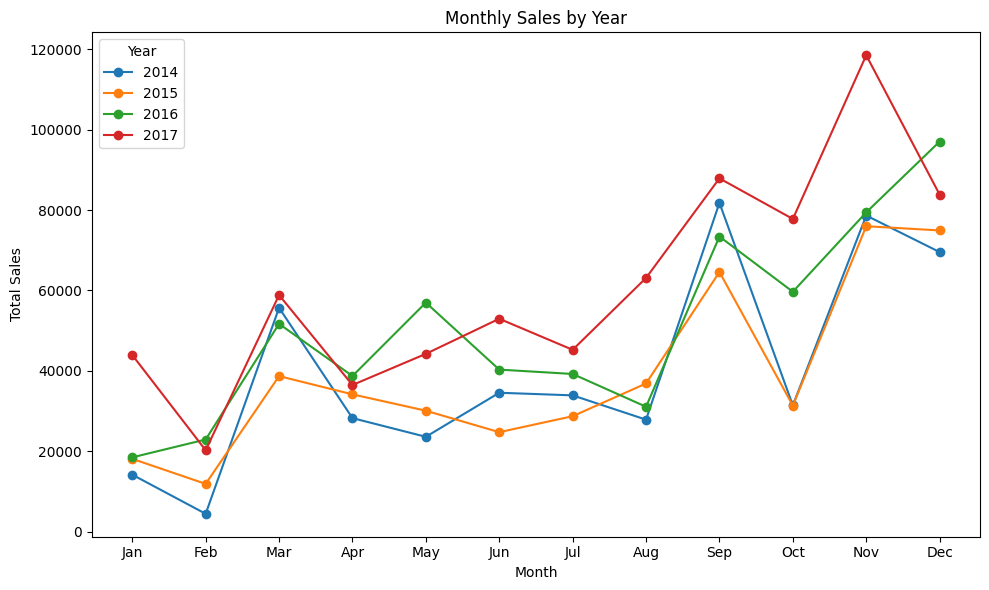

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# Assume you have already run the BigQuery magic into this DataFrame:
df = Sales_trends_over_time_with_seasonality.copy()
# Ensure types
df['sales_year'] = df['sales_year'].astype(int)
df['sales_month'] = df['sales_month'].astype(int)

# Pivot to have months as index and years as columns
pivot = df.pivot(index='sales_month', columns='sales_year', values='total_sales')
pivot = pivot.sort_index()

# Convert month numbers to abbreviated names
pivot.index = pivot.index.map(lambda m: calendar.month_abbr[m])

# Plotting
plt.figure(figsize=(10, 6))
for year in pivot.columns:
    plt.plot(pivot.index, pivot[year], marker='o', label=year)

plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales by Year')
plt.legend(title='Year')
plt.tight_layout()
plt.show()


In [32]:
import pandas as pd
import plotly.express as px

# 1) Prepare the DataFrame
df = superstore.copy()
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Year']       = df['Order_Date'].dt.year

# 2) Aggregate total profit by Sub-Category and Year
yearly_profit = (
    df
    .groupby(['Sub_Category','Year'], as_index=False)
    .agg(Total_Profit=('Profit','sum'))
)

# (Optional) If you have dozens of sub-categories, you can focus on the top N by overall profit:
top_n = (
    df.groupby('Sub_Category')['Profit']
      .sum()
      .nlargest(10)
      .index
      .tolist()
)
yearly_profit = yearly_profit[yearly_profit['Sub_Category'].isin(top_n)]

# 3) Plot a multi-line chart
fig = px.line(
    yearly_profit,
    x='Year',
    y='Total_Profit',
    color='Sub_Category',
    labels={
        'Year': 'Year',
        'Total_Profit': 'Total Profit',
        'Sub_Category': 'Product Sub-Category'
    },
    title='Year-over-Year Total Profit by Sub-Category'
)

# 4) Tidy up the axes and layout
fig.update_layout(
    xaxis=dict(dtick=1),          # show every year on the x-axis
    legend_title_text='Sub-Category',
    height=600,
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.show()
